## Holder analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [21]:
df_contracts = pd.read_csv('../csv_outputs/master_contract.csv')
df_holders_list = pd.read_csv('../csv_outputs/master_holders_list.csv')
df_holders = pd.read_csv('../csv_outputs/master_holders.csv')

df_holders_list.columns

Index(['token_address', 'chain', 'token_name', 'holder_address', 'balance',
       'percentage_of_total_supply', 'percentage_of_circulating_supply'],
      dtype='object')

## Distribution of number of total holders

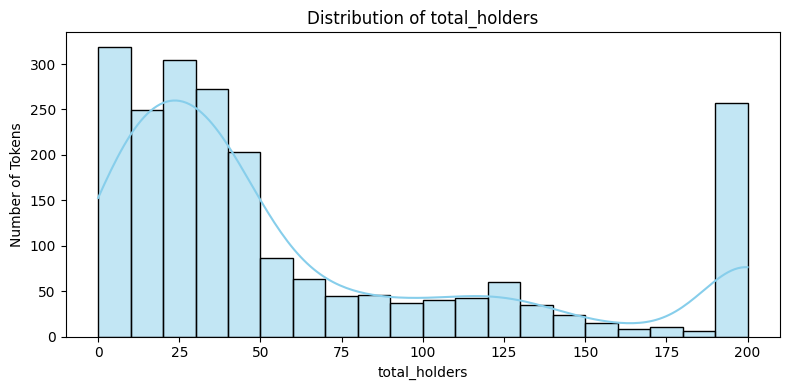

In [4]:
# 1. Distribution of total_holders

df_holders['total_supply'] = pd.to_numeric(df_holders['total_supply'], errors='coerce')

plt.figure(figsize=(8, 4))
plt.title(f'Distribution of total_holders')
sns.histplot(df_holders['total_holders'].dropna(), kde=True, bins=20, color='skyblue')
plt.xlabel('total_holders')
plt.ylabel('Number of Tokens')
plt.tight_layout()
plt.show()


## Owner wallet contains \< 5% of the circulating token supply

/tmp/ipykernel_47951/855554641.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, x='Owner Category', y='Token Count', palette='Set2')


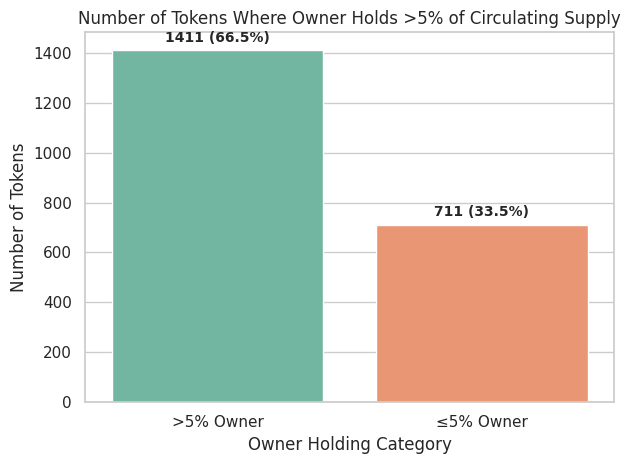

In [14]:
# Owner/creator wallet contains < 5% of circulating token supply

# Load data
df_contracts = pd.read_csv('../csv_outputs/master_contract.csv')
df_holders_list = pd.read_csv('../csv_outputs/master_holders_list.csv')
df_holders = pd.read_csv('../csv_outputs/master_holders.csv')  # has total_circulating_supply

# Merge holder list with contract info (to get owner)
df_merged = df_holders_list.merge(df_contracts[['token_address', 'owner']], on='token_address', how='left')

# Merge with circulating supply
df_merged = df_merged.merge(df_holders[['token_address', 'total_circulating_supply']], on='token_address', how='left')

# Normalize address case
df_merged['holder_address'] = df_merged['holder_address'].str.lower()
df_merged['owner'] = df_merged['owner'].str.lower()

# Filter to only owner rows
df_owner_holdings = df_merged[df_merged['holder_address'] == df_merged['owner']].copy()

# Calculate percent of total supply held by owner
df_owner_holdings['balance'] = pd.to_numeric(df_owner_holdings['balance'], errors='coerce')
df_owner_holdings['total_circulating_supply'] = pd.to_numeric(df_owner_holdings['total_circulating_supply'], errors='coerce')

# Clean bad data
df_owner_holdings = df_owner_holdings.dropna(subset=['balance', 'total_circulating_supply'])
df_owner_holdings = df_owner_holdings[df_owner_holdings['total_circulating_supply'] > 0]

# Calculate owner percentage
df_owner_holdings['owner_percent'] = (df_owner_holdings['balance'] / df_owner_holdings['total_circulating_supply']) * 100

# Determine which tokens exceed 5%
tokens_over_5 = df_owner_holdings[df_owner_holdings['owner_percent'] > 5]['token_address'].nunique()
total_tokens = df_contracts['token_address'].nunique()
tokens_5_or_less = total_tokens - tokens_over_5

# Prepare plot data
plot_df = pd.DataFrame({
    'Owner Category': ['>5% Owner', '≤5% Owner'],
    'Token Count': [tokens_over_5, tokens_5_or_less]
})

# Calculate percentages for labels
plot_df['Percentage'] = (plot_df['Token Count'] / total_tokens) * 100

# Plot
sns.set(style="whitegrid")
ax = sns.barplot(data=plot_df, x='Owner Category', y='Token Count', palette='Set2')

# Annotate each bar with value and percentage
for i, row in plot_df.iterrows():
    count = row['Token Count']
    percent = row['Percentage']
    ax.text(i, count + (total_tokens * 0.01), f'{count} ({percent:.1f}%)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Number of Tokens Where Owner Holds >5% of Circulating Supply")
plt.xlabel("Owner Holding Category")
plt.ylabel("Number of Tokens")
plt.tight_layout()
plt.show()


## Creator wallet contains \< 5% of the circulating token supply

/tmp/ipykernel_47951/163903456.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, x='Creator Category', y='Token Count', palette='Set2')


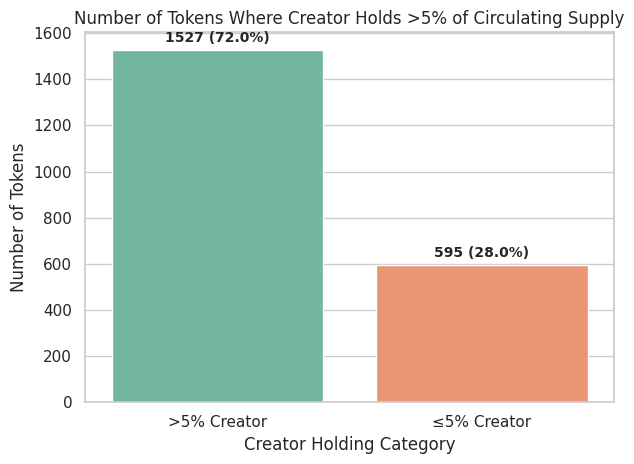

In [15]:
# Load data
df_contracts = pd.read_csv('../csv_outputs/master_contract.csv')
df_holders_list = pd.read_csv('../csv_outputs/master_holders_list.csv')
df_holders = pd.read_csv('../csv_outputs/master_holders.csv')  # has total_circulating_supply

# Merge holder list with contract info (to get creator)
df_merged = df_holders_list.merge(df_contracts[['token_address', 'creator']], on='token_address', how='left')

# Merge with circulating supply
df_merged = df_merged.merge(df_holders[['token_address', 'total_circulating_supply']], on='token_address', how='left')

# Normalize address case
df_merged['holder_address'] = df_merged['holder_address'].str.lower()
df_merged['creator'] = df_merged['creator'].str.lower()

# Filter to only creator rows
df_creator_holdings = df_merged[df_merged['holder_address'] == df_merged['creator']].copy()

# Calculate percent of total supply held by creator
df_creator_holdings['balance'] = pd.to_numeric(df_creator_holdings['balance'], errors='coerce')
df_creator_holdings['total_circulating_supply'] = pd.to_numeric(df_creator_holdings['total_circulating_supply'], errors='coerce')

# Clean bad data
df_creator_holdings = df_creator_holdings.dropna(subset=['balance', 'total_circulating_supply'])
df_creator_holdings = df_creator_holdings[df_creator_holdings['total_circulating_supply'] > 0]

# Calculate creator percentage
df_creator_holdings['creator_percent'] = (df_creator_holdings['balance'] / df_creator_holdings['total_circulating_supply']) * 100

# Determine which tokens exceed 5%
tokens_over_5 = df_creator_holdings[df_creator_holdings['creator_percent'] > 5]['token_address'].nunique()
total_tokens = df_contracts['token_address'].nunique()
tokens_5_or_less = total_tokens - tokens_over_5

# Prepare plot data
plot_df = pd.DataFrame({
    'Creator Category': ['>5% Creator', '≤5% Creator'],
    'Token Count': [tokens_over_5, tokens_5_or_less]
})

# Calculate percentages for labels
plot_df['Percentage'] = (plot_df['Token Count'] / total_tokens) * 100

# Plot
sns.set(style="whitegrid")
ax = sns.barplot(data=plot_df, x='Creator Category', y='Token Count', palette='Set2')

# Annotate each bar with value and percentage
for i, row in plot_df.iterrows():
    count = row['Token Count']
    percent = row['Percentage']
    ax.text(i, count + (total_tokens * 0.01), f'{count} ({percent:.1f}%)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Number of Tokens Where Creator Holds >5% of Circulating Supply")
plt.xlabel("Creator Holding Category")
plt.ylabel("Number of Tokens")
plt.tight_layout()
plt.show()


/tmp/ipykernel_47951/2748027614.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x='Holder Category', y='Token Count', palette='coolwarm')


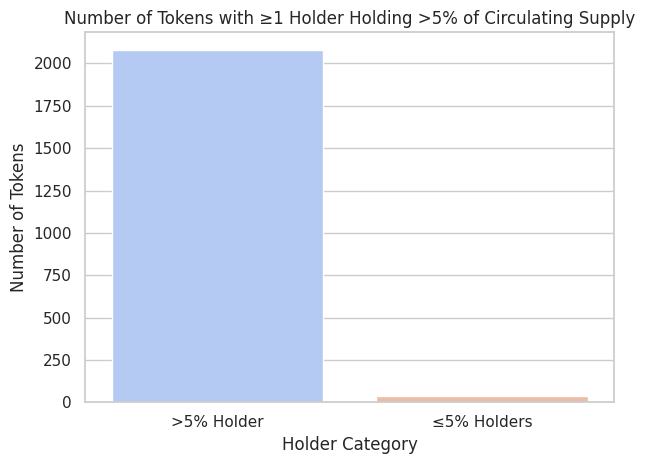

In [6]:
# Load data
df_contracts = pd.read_csv('../csv_outputs/master_contract.csv')  # has token_address, owner
df_holders_list = pd.read_csv('../csv_outputs/master_holders_list.csv')  # has token_address, holder_address, balance
df_holders = pd.read_csv('../csv_outputs/master_holders.csv')  # has token_address, total_circulating_supply

# Merge holders with total circulating supply
df_all = df_holders_list.merge(df_holders[['token_address', 'total_circulating_supply']], on='token_address', how='left')

# Convert to lowercase to standardize addresses
df_all['holder_address'] = df_all['holder_address'].str.lower()

# Convert balance and supply to numeric
df_all['balance'] = pd.to_numeric(df_all['balance'], errors='coerce')
df_all['total_circulating_supply'] = pd.to_numeric(df_all['total_circulating_supply'], errors='coerce')

# Drop rows with invalid or zero supply
df_all = df_all.dropna(subset=['balance', 'total_circulating_supply'])
df_all = df_all[df_all['total_circulating_supply'] > 0]

# Calculate holder's percent of supply
df_all['holder_percent'] = (df_all['balance'] / df_all['total_circulating_supply']) * 100

# Count unique tokens with at least one holder over 5%
tokens_with_holder_over_5 = df_all[df_all['holder_percent'] > 5]['token_address'].nunique()
total_tokens = df_all['token_address'].nunique()

# Prepare data for plotting
plot_df = pd.DataFrame({
    'Holder Category': ['>5% Holder', '≤5% Holders'],
    'Token Count': [tokens_with_holder_over_5, total_tokens - tokens_with_holder_over_5]
})

# Plot
sns.set(style="whitegrid")
sns.barplot(data=plot_df, x='Holder Category', y='Token Count', palette='coolwarm')
plt.title("Number of Tokens with ≥1 Holder Holding >5% of Circulating Supply")
plt.xlabel("Holder Category")
plt.ylabel("Number of Tokens")
plt.tight_layout()
plt.show()

## Top 10 holder % distribution compared to total and circulating supply

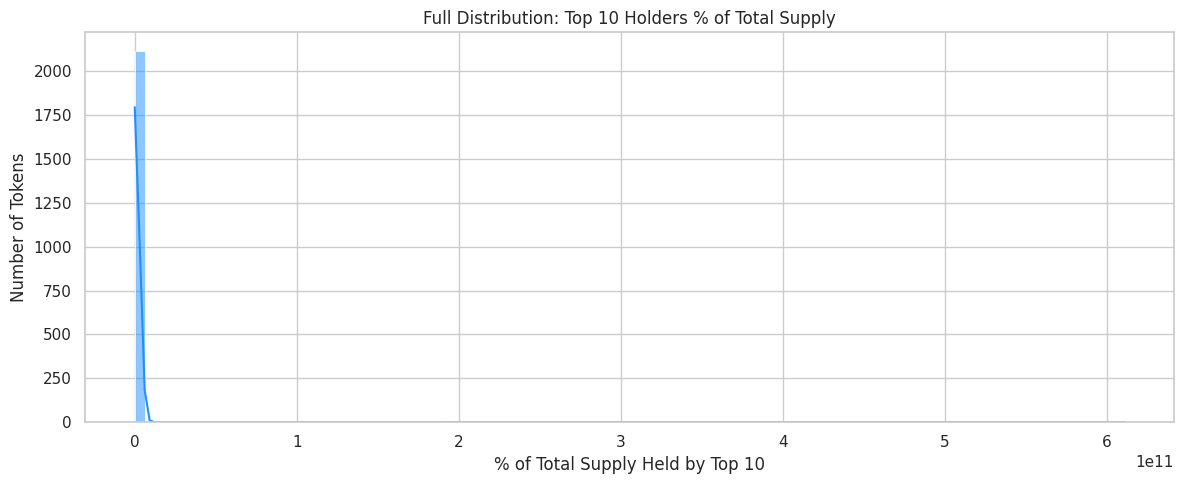

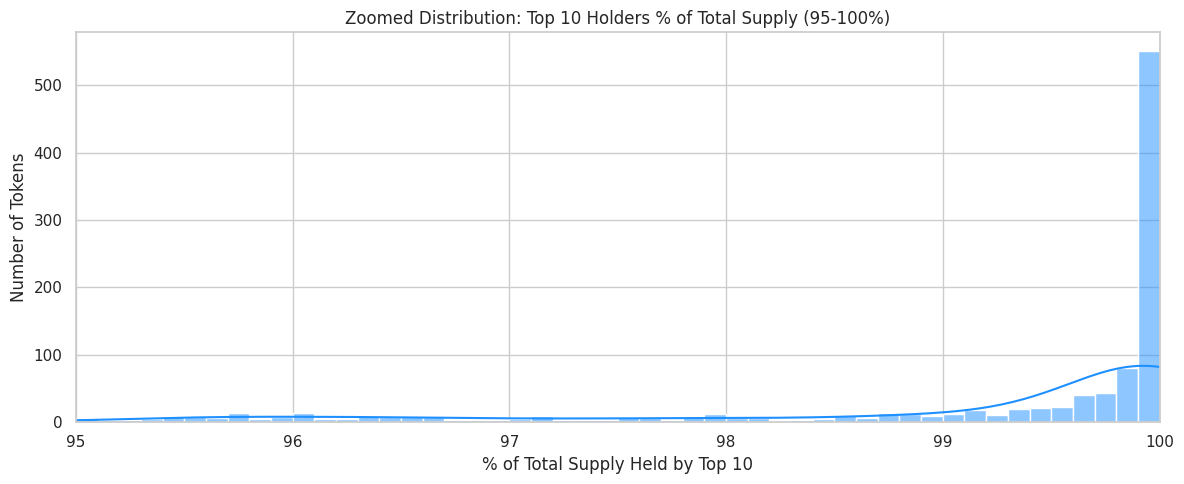

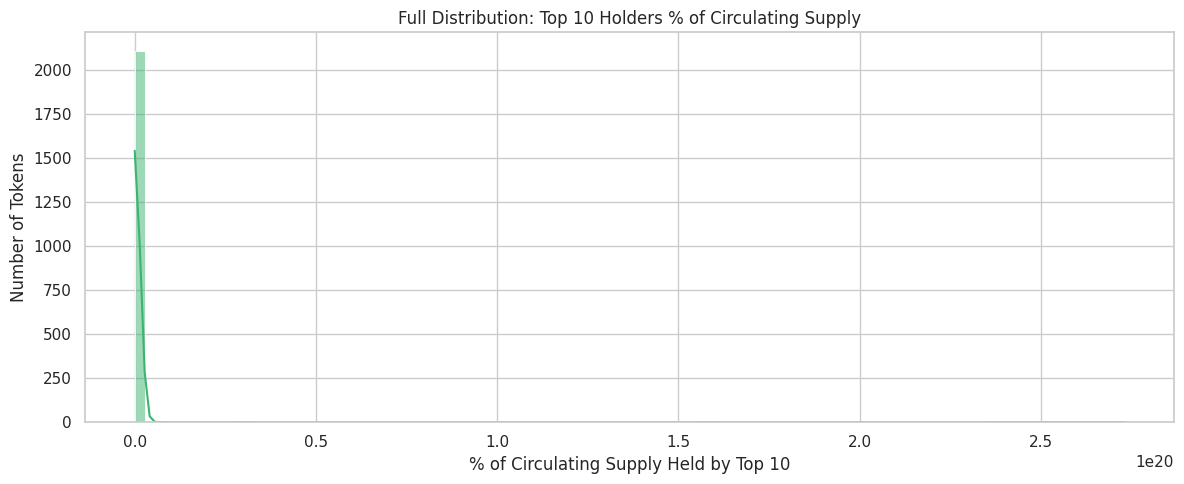

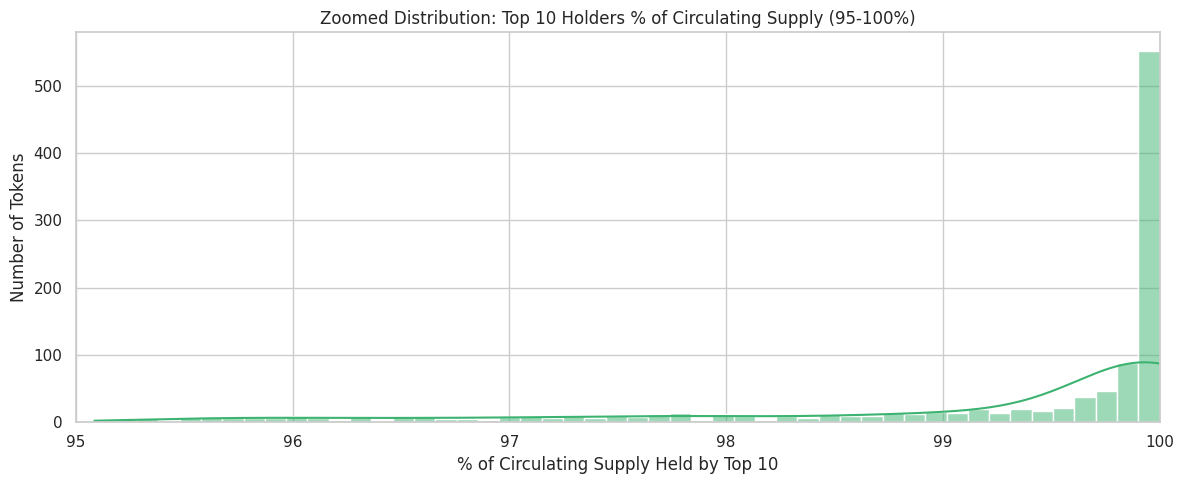

In [7]:
# Ensure columns are numeric (in case they were read as strings)
total_pct = pd.to_numeric(df_holders['top10_percentage_of_total_supply'], errors='coerce').dropna()
circ_pct = pd.to_numeric(df_holders['top10_percentage_of_circulating_supply'], errors='coerce').dropna()

# --- Plot full distribution for total supply percentage
plt.figure(figsize=(12, 5))
sns.histplot(total_pct, bins=100, kde=True, color='dodgerblue')
plt.title('Full Distribution: Top 10 Holders % of Total Supply')
plt.xlabel('% of Total Supply Held by Top 10')
plt.ylabel('Number of Tokens')
plt.tight_layout()
plt.show()

# --- Plot zoomed-in distribution for total supply percentage (95-100%)
plt.figure(figsize=(12, 5))
sns.histplot(total_pct[(total_pct >= 95) & (total_pct <= 100)], bins=50, kde=True, color='dodgerblue')
plt.title('Zoomed Distribution: Top 10 Holders % of Total Supply (95-100%)')
plt.xlabel('% of Total Supply Held by Top 10')
plt.ylabel('Number of Tokens')
plt.xlim(95, 100)
plt.tight_layout()
plt.show()

# --- Plot full distribution for circulating supply percentage
plt.figure(figsize=(12, 5))
sns.histplot(circ_pct, bins=100, kde=True, color='mediumseagreen')
plt.title('Full Distribution: Top 10 Holders % of Circulating Supply')
plt.xlabel('% of Circulating Supply Held by Top 10')
plt.ylabel('Number of Tokens')
plt.tight_layout()
plt.show()

# --- Plot zoomed-in distribution for circulating supply percentage (95-100%)
plt.figure(figsize=(12, 5))
sns.histplot(circ_pct[(circ_pct >= 95) & (circ_pct <= 100)], bins=50, kde=True, color='mediumseagreen')
plt.title('Zoomed Distribution: Top 10 Holders % of Circulating Supply (95-100%)')
plt.xlabel('% of Circulating Supply Held by Top 10')
plt.ylabel('Number of Tokens')
plt.xlim(95, 100)
plt.tight_layout()
plt.show()

/tmp/ipykernel_47951/3386190986.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_supply'] = pd.to_numeric(df_holders['total_supply'], errors='coerce')


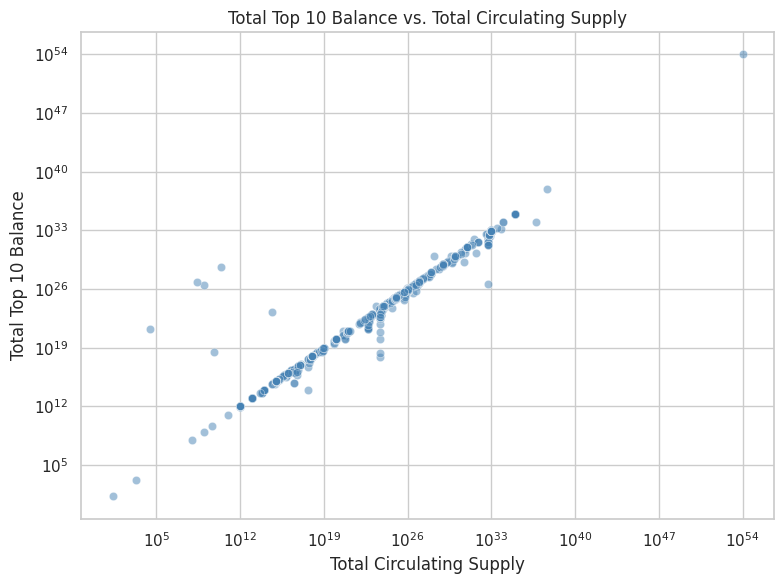

In [8]:
# Step 1: Convert to numeric
df_holders['total_top_10_balance'] = pd.to_numeric(df_holders['total_top_10_balance'], errors='coerce')
df_holders['total_circulating_supply'] = pd.to_numeric(df_holders['total_circulating_supply'], errors='coerce')

# Step 2: Filter out missing or invalid values
df = df_holders.dropna(subset=['total_top_10_balance', 'total_circulating_supply'])
df['total_supply'] = pd.to_numeric(df_holders['total_supply'], errors='coerce')
df = df[df['total_supply'] > 0]  # avoid divide-by-zero

# Step 3: Calculate ratio (float division)
df['top10_vs_circulating_ratio'] = df['total_top_10_balance'] / df['total_circulating_supply']


plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='total_circulating_supply',
    y='total_top_10_balance',
    alpha=0.5,
    color='steelblue'
)
plt.title('Total Top 10 Balance vs. Total Circulating Supply')
plt.xlabel('Total Circulating Supply')
plt.ylabel('Total Top 10 Balance')
plt.xscale('log')  # Use log scale if the values vary widely
plt.yscale('log')
plt.tight_layout()
plt.show()

## Top 10 token holders possess < 70% of circulating token supply (no locking addresses)

/tmp/ipykernel_47951/1139852702.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_holders, x='top_10_less_than_70_percent_of_total', palette='Set2')


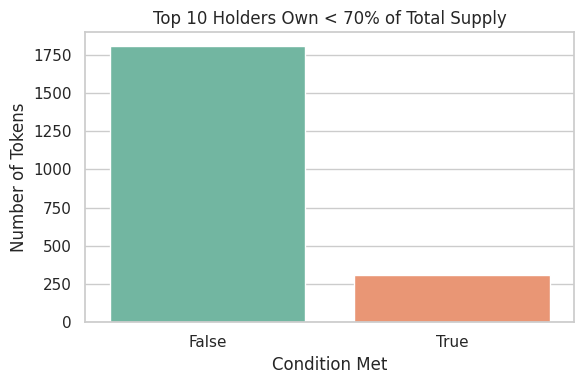

/tmp/ipykernel_47951/1139852702.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_holders, x='top_10_less_than_70_percent_of_circulating', palette='Set3')


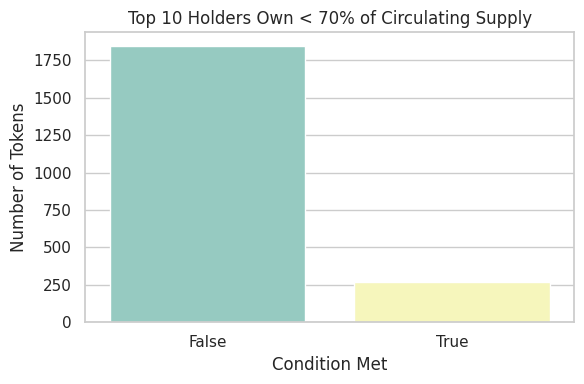

In [9]:
# Plot 1: top_10_less_than_70_percent_of_total
plt.figure(figsize=(6, 4))
sns.countplot(data=df_holders, x='top_10_less_than_70_percent_of_total', palette='Set2')
plt.title('Top 10 Holders Own < 70% of Total Supply')
plt.xlabel('Condition Met')
plt.ylabel('Number of Tokens')
plt.xticks([0, 1], ['False', 'True'])
plt.tight_layout()
plt.show()

# Plot 2: top_10_less_than_70_percent_of_circulating
plt.figure(figsize=(6, 4))
sns.countplot(data=df_holders, x='top_10_less_than_70_percent_of_circulating', palette='Set3')
plt.title('Top 10 Holders Own < 70% of Circulating Supply')
plt.xlabel('Condition Met')
plt.ylabel('Number of Tokens')
plt.xticks([0, 1], ['False', 'True'])
plt.tight_layout()
plt.show()

In [19]:
df_holders_list

,token_address,chain,token_name,holder_address,balance,percentage_of_total_supply,percentage_of_circulating_supply
0,0x002127Ec60f4b0F75F7AE20565D1d0cd99993dD3,bsc,ZTU COIN,0x75daea4669b4a9da51f9f2da8517ef2e99de8dbb,2638319057212735727075328,3.297899e+01,3.297899e+01
1,0x002127Ec60f4b0F75F7AE20565D1d0cd99993dD3,bsc,ZTU COIN,0xddb2771e722683d35f86ed9de71ac40f3572a1f5,2487034777709162482630656,3.108793e+01,3.108793e+01
2,0x002127Ec60f4b0F75F7AE20565D1d0cd99993dD3,bsc,ZTU COIN,0x0ed943ce24baebf257488771759f9bf482c39706,59845990931374100447232,7.480749e-01,7.480749e-01
3,0x002127Ec60f4b0F75F7AE20565D1d0cd99993dD3,bsc,ZTU COIN,0x37ba0098c831a1629d48ab71477f62a6869f0de5,54973305733385407168512,6.871663e-01,6.871663e-01
4,0x002127Ec60f4b0F75F7AE20565D1d0cd99993dD3,bsc,ZTU COIN,0x91e08ed6ef025ea5e47c7cccd761062c707ac9aa,13850105097108699742208,1.731263e-01,1.731263e-01
...,...,...,...,...,...,...,...
132378,0xFFEB21c405b2c1F484b3C8Ac0f608D9a7f86c5b2,bsc,SluttyDoge,0xe471bc36cacb1ed49ad08d229c13d9ea9330443d,28828288623007,2.882829e-09,5.497027e-09
132379,0xFFEB21c405b2c1F484b3C8Ac0f608D9a7f86c5b2,bsc,SluttyDoge,0xacf4eab9b901fd87e9d935d6c81347ddf40825e7,1418853197537,1.418853e-10,2.705493e-10
132380,0xFFEB21c405b2c1F484b3C8Ac0f608D9a7f86c5b2,bsc,SluttyDoge,0x2156182ab03684a6042bf6e4dcbbc79ac5bec8f2,760000000,7.600000e-14,1.449181e-13
132381,0xFFEB21c405b2c1F484b3C8Ac0f608D9a7f86c5b2,bsc,SluttyDoge,0xfbf7aa38eaf0c907b74bd310a46892aadd549277,515352817,5.153528e-14,9.826835e-14


## All other holders possess < 5% of circulating token supply (Not a single one has > 5%)

/tmp/ipykernel_47951/1930208331.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, x='Holder Concentration', y='Token Count', palette='Set2')


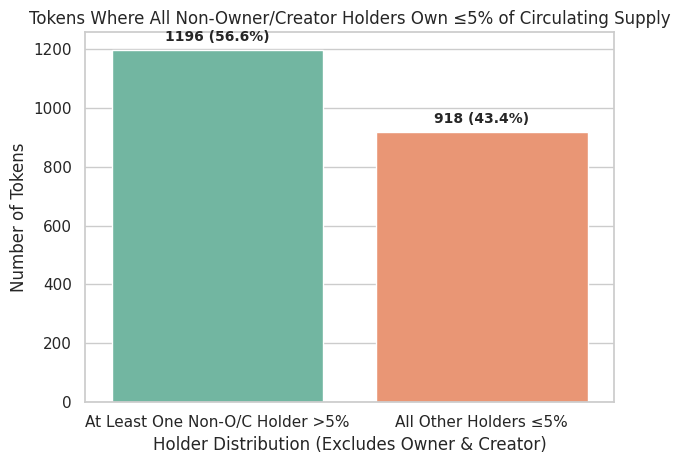

In [18]:
# Analyze tokens where no single non-owner/creator holder owns >5% of circulating supply

# Normalize address case
df_holders_list['holder_address'] = df_holders_list['holder_address'].str.lower()
df_contracts['owner'] = df_contracts['owner'].str.lower()
df_contracts['creator'] = df_contracts['creator'].str.lower()

# Merge holders list with owner and creator info
df_holders_enriched = df_holders_list.merge(
    df_contracts[['token_address', 'owner', 'creator']], on='token_address', how='left'
)

# Exclude owner and creator addresses
df_filtered = df_holders_enriched[
    (df_holders_enriched['holder_address'] != df_holders_enriched['owner']) &
    (df_holders_enriched['holder_address'] != df_holders_enriched['creator'])
].copy()

# Convert to numeric if necessary
df_filtered['percentage_of_circulating_supply'] = pd.to_numeric(
    df_filtered['percentage_of_circulating_supply'], errors='coerce'
)

# Drop any remaining NaNs just in case
df_filtered = df_filtered.dropna(subset=['percentage_of_circulating_supply'])

# Group by token and find max holder share (excluding owner/creator)
token_check = df_filtered.groupby('token_address')['percentage_of_circulating_supply'].max().reset_index()

# Classify tokens
token_check['Holder Concentration'] = token_check['percentage_of_circulating_supply'].apply(
    lambda x: 'All Other Holders ≤5%' if x <= 5 else 'At Least One Non-O/C Holder >5%'
)

# Count how many tokens fall in each category
plot_df = token_check['Holder Concentration'].value_counts().reset_index()
plot_df.columns = ['Holder Concentration', 'Token Count']

# Calculate total tokens for percentage labels
total_tokens = token_check['token_address'].nunique()
plot_df['Percentage'] = (plot_df['Token Count'] / total_tokens) * 100

# Plot
sns.set(style="whitegrid")
ax = sns.barplot(data=plot_df, x='Holder Concentration', y='Token Count', palette='Set2')

# Annotate each bar with count and percentage
for i, row in plot_df.iterrows():
    count = row['Token Count']
    percent = row['Percentage']
    ax.text(i, count + (total_tokens * 0.01), f'{count} ({percent:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Tokens Where All Non-Owner/Creator Holders Own ≤5% of Circulating Supply")
plt.xlabel("Holder Distribution (Excludes Owner & Creator)")
plt.ylabel("Number of Tokens")
plt.tight_layout()
plt.show()
